# 1. Install Dependencies and Setup


In [1]:
# !pip install tensorflow opencv-python
# tensorflow-gpu matplotlib

In [2]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load Data


### 2.1 Load Images


In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files("data/train_aug/images/*.jpg", shuffle=False)
# train_images = tf.data.Dataset.list_files('data\\train_aug\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x / 255)

In [6]:
test_images = tf.data.Dataset.list_files("data/test_aug/images/*.jpg", shuffle=False)

# test_images = tf.data.Dataset.list_files('data\\test_aug\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x / 255)

In [7]:
val_images = tf.data.Dataset.list_files("data/val_aug/images/*.jpg", shuffle=False)

# val_images = tf.data.Dataset.list_files('data\\val_aug\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x / 255)

### 2.2 Prepare Labels


In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding="utf-8") as f:
        label = json.load(f)
    return [label["keypoints"]]

In [9]:
train_labels = tf.data.Dataset.list_files("data/train_aug/labels/*.json", shuffle=False)
train_labels = train_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.float16])
)

In [10]:
train_labels.as_numpy_iterator().next()
# x left eye, y left eye, x right eye, y right eye

(array([0.651 , 0.381 , 0.4421, 0.3823], dtype=float16),)

In [11]:
test_labels = tf.data.Dataset.list_files("data/test_aug/labels/*.json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [12]:
val_labels = tf.data.Dataset.list_files("data/val_aug/labels/*.json", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3. Combine Labels and Images


In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [14]:
train.as_numpy_iterator().next()

(array([[[[0.459451  , 0.42415687, 0.44376472],
          [0.44768625, 0.41239214, 0.43199998],
          [0.44211763, 0.40682352, 0.41858822],
          ...,
          [0.48666668, 0.447451  , 0.44352943],
          [0.4912518 , 0.4520361 , 0.44811454],
          [0.49184313, 0.45262745, 0.44870588]],
 
         [[0.46047062, 0.4251765 , 0.4369412 ],
          [0.4509804 , 0.41568628, 0.42745098],
          [0.45189804, 0.4087608 , 0.42444706],
          ...,
          [0.48797652, 0.44876084, 0.44483927],
          [0.49411765, 0.45490196, 0.4509804 ],
          [0.49141487, 0.4521992 , 0.44435605]],
 
         [[0.4749098 , 0.4396157 , 0.4513804 ],
          [0.46695685, 0.4238196 , 0.43950588],
          [0.4627451 , 0.41960785, 0.43529412],
          ...,
          [0.49172553, 0.45250985, 0.44858828],
          [0.49552932, 0.45631364, 0.4484705 ],
          [0.49411765, 0.45490196, 0.44705883]],
 
         ...,
 
         [[0.22186674, 0.15912165, 0.17088635],
          [0.23891

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [16]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples


In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

In [19]:
res

(array([[[[0.5137255 , 0.5882353 , 0.57254905],
          [0.51474506, 0.58925486, 0.5735686 ],
          [0.5180392 , 0.592549  , 0.5690196 ],
          ...,
          [0.78988236, 0.7977255 , 0.77811766],
          [0.78882664, 0.7966698 , 0.77706194],
          [0.7882353 , 0.79607844, 0.7764706 ]],
 
         [[0.5180753 , 0.5925851 , 0.5768988 ],
          [0.51942116, 0.59393096, 0.5782447 ],
          [0.5225882 , 0.597098  , 0.5735686 ],
          ...,
          [0.7985882 , 0.8025098 , 0.78290194],
          [0.79505885, 0.7989804 , 0.7793726 ],
          [0.79607844, 0.8       , 0.78039217]],
 
         [[0.5176471 , 0.5921569 , 0.5764706 ],
          [0.52117646, 0.59568626, 0.57215685],
          [0.52192163, 0.59643143, 0.572902  ],
          ...,
          [0.792549  , 0.7964706 , 0.77686274],
          [0.7951609 , 0.79908246, 0.7794746 ],
          [0.79607844, 0.8       , 0.7764706 ]],
 
         ...,
 
         [[0.4117647 , 0.47058824, 0.4509804 ],
          [0.40784

In [20]:
res[0].shape

(16, 250, 250, 3)

In [21]:
np.multiply(res[1][0][0], [250, 250, 250, 250])

array([  0.        ,   0.        , 180.29785156, 105.10253906])

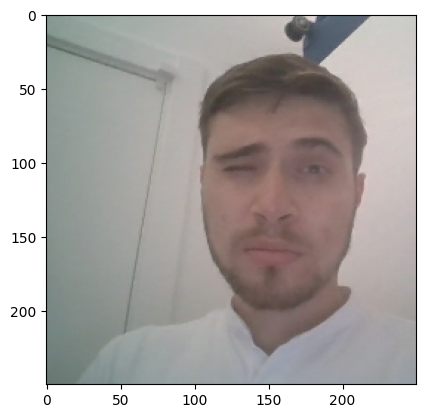

In [22]:
plt.imshow(res[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


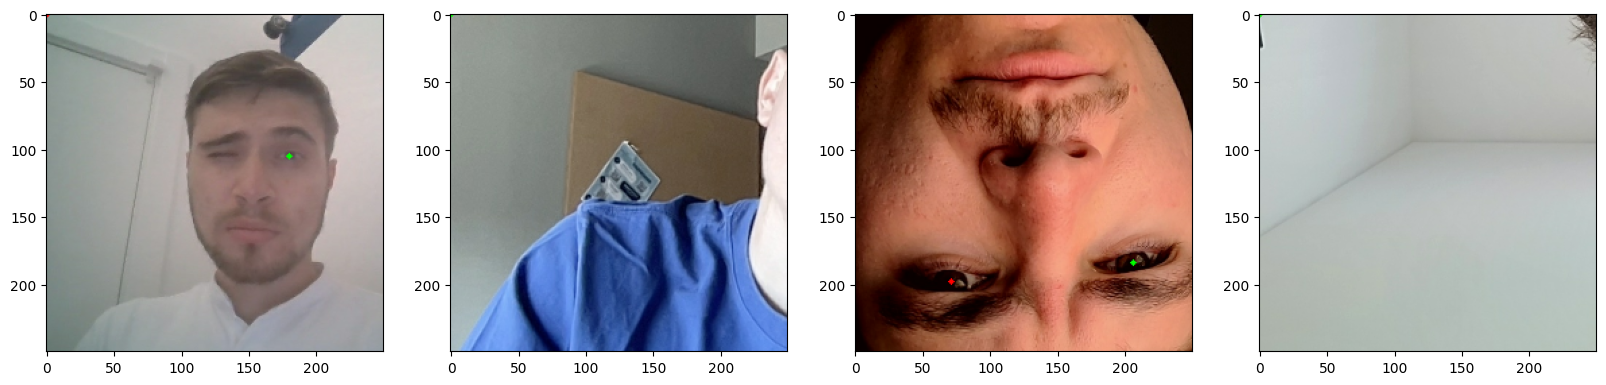

In [23]:
# sample_image_writable = res.copy()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][0][idx]

    cv2.circle(
        sample_image,
        tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)),
        2,
        (255, 0, 0),
        -1,
    )
    cv2.circle(
        sample_image,
        tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)),
        2,
        (0, 255, 0),
        -1,
    )

    ax[idx].imshow(sample_image)

# 3. Build Model


### 3.1 Create Neural Network


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [25]:
model = Sequential(
    [
        Input(shape=(250, 250, 3)),
        ResNet152V2(include_top=False, input_shape=(250, 250, 3)),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(512, 3, padding="same", activation="relu"),
        Conv2D(256, 3, 2, padding="same", activation="relu"),
        Conv2D(256, 2, 2, activation="relu"),
        Dropout(0.05),
        Conv2D(4, 2, 2),
        Reshape((4,)),
    ]
)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

### 3.2 Setup Losses and Optimizer


In [27]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [28]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions


In [29]:
X, y = train.as_numpy_iterator().next()

In [30]:
X.shape

(16, 250, 250, 3)

In [31]:
scores = model.predict(X)

1/1 [==============================] - 5s 5s/step


In [32]:
scores

array([[ 1.11845315e+00,  1.38524222e+00,  4.08060223e-01,
        -5.58619738e-01],
       [-1.88352168e-01, -8.27610493e-05,  4.75469142e-01,
        -7.45687544e-01],
       [ 1.13885784e+00,  2.04854202e+00,  9.80352819e-01,
        -1.49048829e+00],
       [ 8.71421635e-01,  5.70430934e-01,  9.89415169e-01,
        -7.12452888e-01],
       [ 9.43976998e-01,  4.26062286e-01,  5.30825436e-01,
        -1.11422098e+00],
       [ 5.31448841e-01,  4.30848077e-02,  1.55297324e-01,
        -6.07949317e-01],
       [ 4.55349475e-01,  1.44281209e+00, -5.74843585e-02,
        -7.25863054e-02],
       [-2.88303420e-02,  1.26816988e-01,  3.62401485e-01,
        -4.86429274e-01],
       [ 1.06461614e-01,  1.65590250e+00, -1.29532024e-01,
        -2.88195044e-01],
       [ 5.54359913e-01,  6.55612528e-01,  1.11170419e-01,
        -4.16022480e-01],
       [ 1.41774154e+00,  6.36434674e-01,  1.56053007e+00,
        -5.35308897e-01],
       [ 5.17365277e-01,  1.13690305e+00,  8.00569415e-01,
      

### 3.4 Train the Model


There are a few reasons why this might happen:

**Different Data Distributions**: Sometimes the validation data may have a slightly different distribution that the model may perform better on, especially if the validation set is not a perfectly representative subset of the training data.

**Small Validation Set**: If the validation set is much smaller than the training set, the loss might not be a reliable indicator of overall performance. A few easy-to-predict examples could skew the results.

<br>

**Regularization**: If the model includes regularization techniques like dropout, it might perform better on the validation set because during training, some neurons are turned off (to prevent overfitting), which doesn't happen during the validation phase.

**Random Chance**: Particularly in the early stages of training, it is possible to get better performance on the validation set by random chance.

**Data Leakage**: Sometimes, if there is overlap between the training and validation sets due to incorrect data splitting, it could appear as if the model is performing better on validation data.

**Error in Loss Calculation**: It’s also worth ensuring there isn’t a bug in the code or the way the loss is calculated and reported.

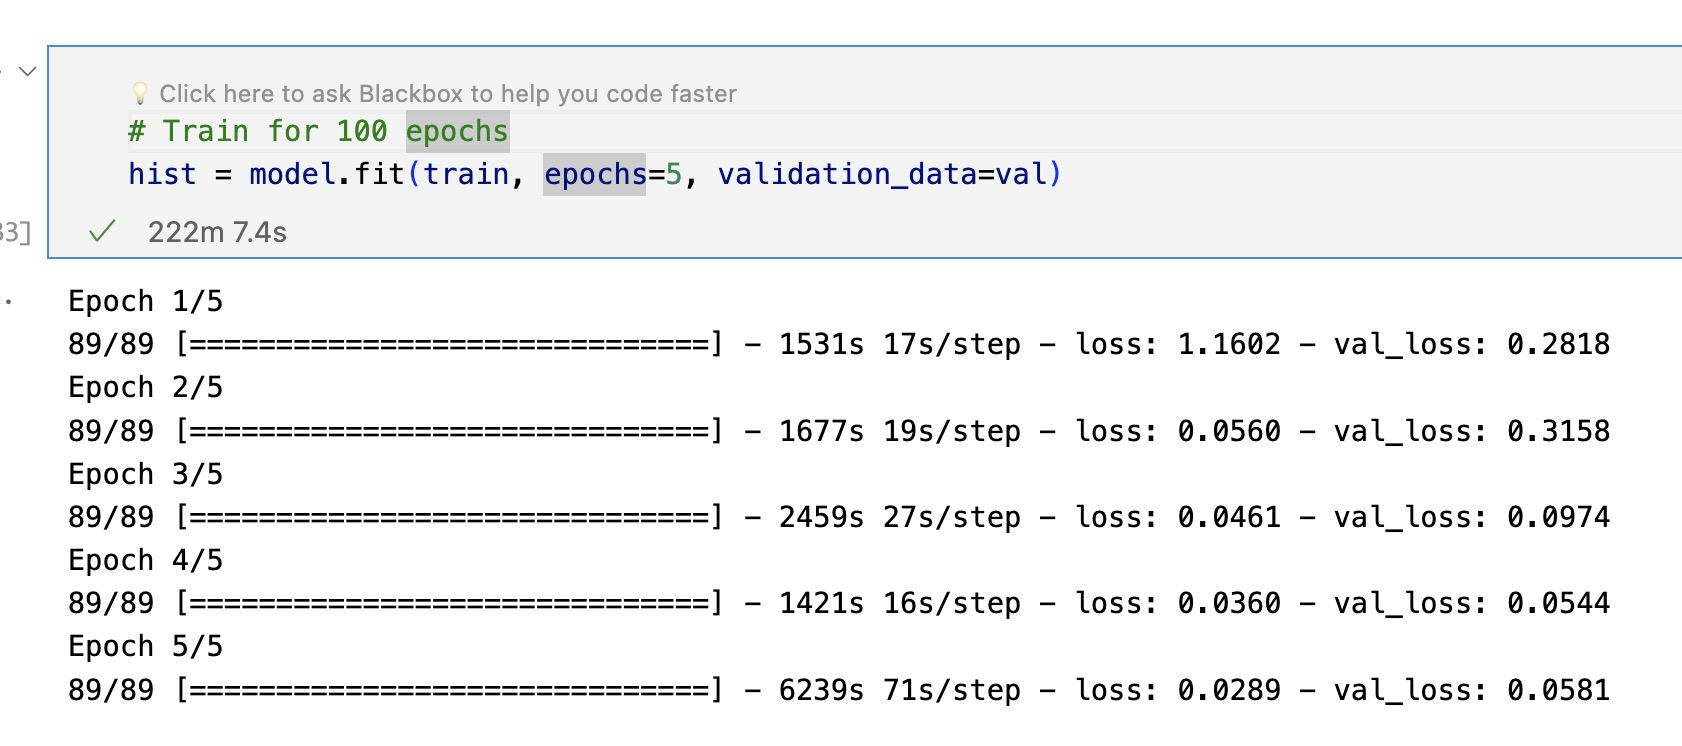


In [33]:
# Train for 100 epochs
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


89/89 [==============================] - 1531s 17s/step - loss: 1.1602 - val_loss: 0.2818
Epoch 2/5
89/89 [==============================] - 1677s 19s/step - loss: 0.0560 - val_loss: 0.3158
Epoch 3/5
89/89 [==============================] - 2459s 27s/step - loss: 0.0461 - val_loss: 0.0974
Epoch 4/5
89/89 [==============================] - 1421s 16s/step - loss: 0.0360 - val_loss: 0.0544
Epoch 5/5
89/89 [==============================] - 6239s 71s/step - loss: 0.0289 - val_loss: 0.0581


# 4. Review Performance


### 4.1 View Loss Plots


In [34]:
hist.history

{'loss': [1.1601873636245728,
  0.056030336767435074,
  0.04608449339866638,
  0.036021023988723755,
  0.02890009805560112],
 'val_loss': [0.2817699909210205,
  0.3158097267150879,
  0.09743358939886093,
  0.05443582683801651,
  0.058106765151023865]}

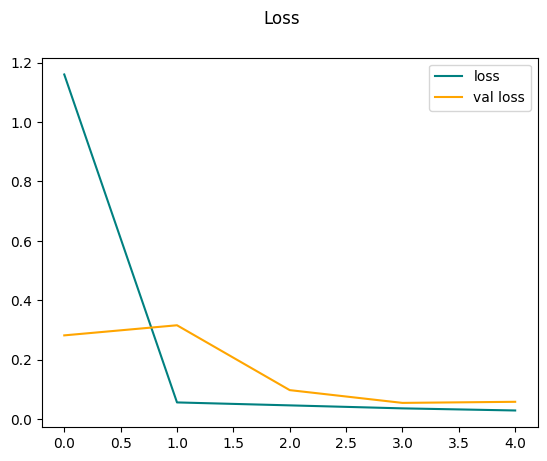

In [35]:
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val loss")
plt.suptitle("Loss")
plt.legend()
plt.show()

### 4.2. Make Predictions on Test


In [36]:
test_data = test.as_numpy_iterator()

In [37]:
test_sample = test_data.next()

In [38]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 4s 4s/step


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


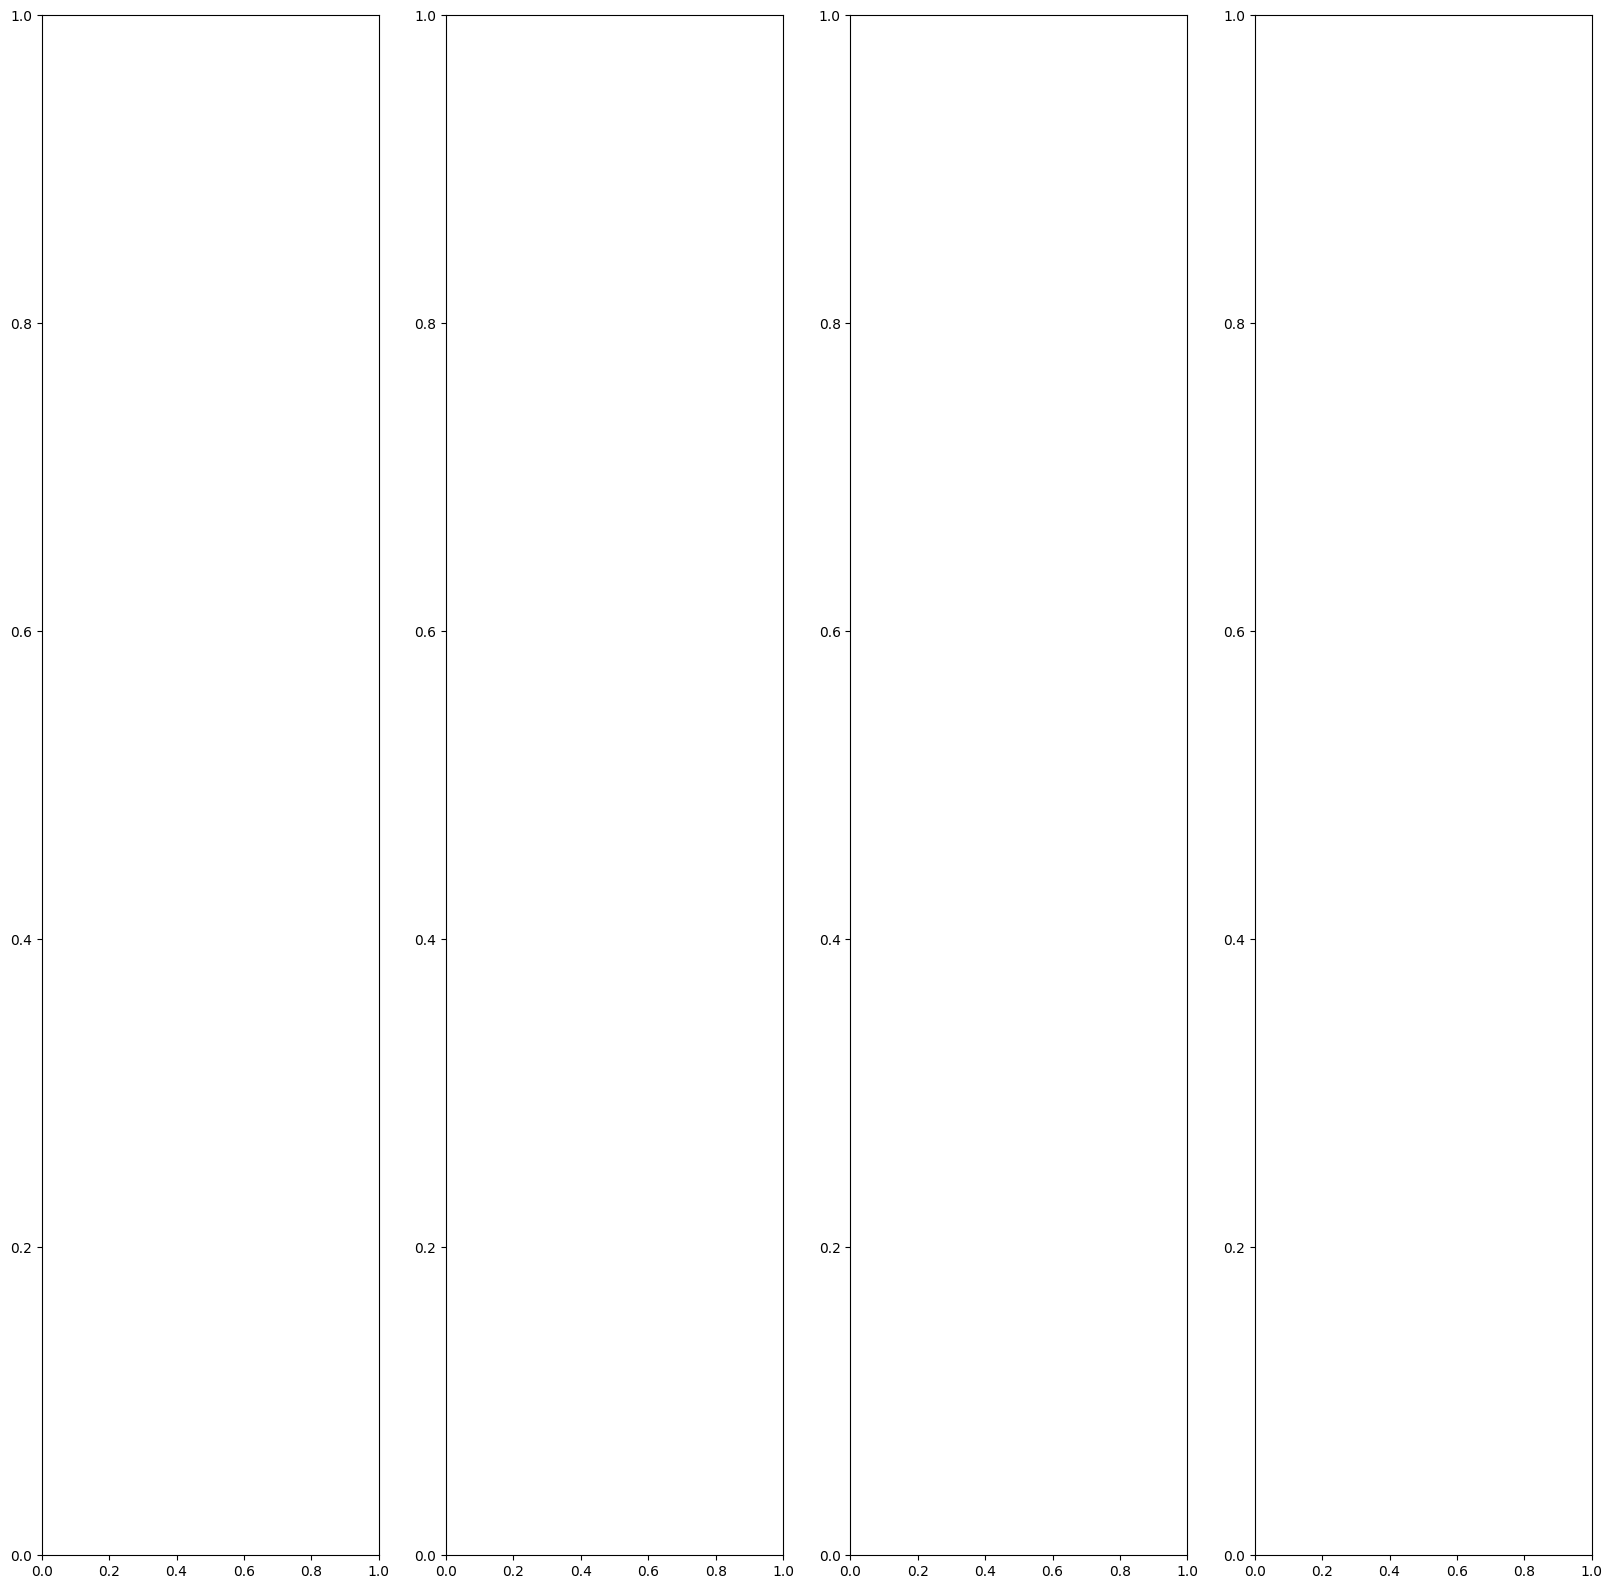

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]

    cv2.circle(
        sample_image,
        tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)),
        2,
        (255, 0, 0),
        -1,
    )
    cv2.circle(
        sample_image,
        tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)),
        2,
        (0, 255, 0),
        -1,
    )

    ax[idx].imshow(sample_image)

### 4.3. Save the Model


In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save("eyetrackerresnet.h5")

/Users/peterfalterbaum/anaconda3/envs/ProgrammingDS/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model = load_model("eyetrackerresnet.h5")

In [43]:
model.predict(test_sample[0])

1/1 [==============================] - 5s 5s/step


array([[-0.01595877, -0.02694788,  0.06226623,  0.0225804 ],
       [ 0.44576833,  0.37046853,  0.39235884,  0.29783845],
       [ 0.01832629,  0.02076698, -0.00251424, -0.00230052],
       [ 0.220974  ,  0.23545521,  0.4078232 ,  0.43336695],
       [ 0.20460549,  0.64565766,  0.28342614,  0.60599875],
       [ 0.03083288,  0.27387962,  0.08495668,  0.1826602 ],
       [ 0.01428997,  0.32917044,  0.14770171,  0.34455526],
       [-0.0121689 , -0.02231944,  0.05234042,  0.0180831 ],
       [ 0.12549408, -0.01007451,  0.16232157,  0.11530594],
       [-0.00085108, -0.00136209,  0.06009679,  0.02534008],
       [-0.00075612,  0.00130264,  0.05813616,  0.02853411],
       [-0.00890324, -0.02287058,  0.05417106,  0.01394499],
       [ 0.65833634,  0.40241167,  0.7159685 ,  0.44566643],
       [ 0.35158968,  0.5557193 ,  0.50401634,  0.65830475],
       [ 0.3101913 ,  0.13408192,  0.5786302 ,  0.35086623],
       [ 0.1747661 ,  0.18116194,  0.5269819 ,  0.5201608 ]],
      dtype=float32)

# 5. Real Time Detection


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()

    frame = frame[50:500, 50:500, :]
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250, 250))

    yhat = model.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[0, :4]

    cv2.circle(
        frame,
        tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
        2,
        (255, 0, 0),
        -1,
    )
    cv2.circle(
        frame,
        tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
        2,
        (0, 255, 0),
        -1,
    )

    cv2.imshow("EyeTrack", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()